# MuTrans script: PDX cisplatin

## PDX entry

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
import matplotlib.pyplot as plt
import pyMuTrans as pm
import hdf5plugin
import gc
import seaborn as sns

datadir = "data/"

In [ ]:
adata = sc.read(datadir+'pdx_entry_seurat.h5ad')
adata

In [ ]:
adata.layers["raw_counts"] = adata.raw.X
adata.layers["seurat_lognorm"] = adata.X
adata.X = adata.raw.X

In [ ]:
adata.obs = adata.obs[['Sample', 'Barcode', 'description', 'Model', 'Condition', 'Rec', 'Replicate', 'batch', 'Sample_Type', 'seurat_clusters', 'MES.Sig', 'ADRN.Sig', 'AMT.Sig', 'AMT.score', 'AMT.state', 'Cluster_Name', 'Coexprs.Sig']]
adata.obsm = []
adata

In [ ]:
# Check adata has raw counts matrix
df = pd.DataFrame.sparse.from_spmatrix(adata.X)
df.head(10)

In [ ]:
sc.pp.subsample(adata, n_obs=20000)
adata

### Pre-processing

Quick QC

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

Normalisation

In [ ]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
# Set .raw attribute of AnnData object to the normalised and logarithmized raw gene expression
adata.raw = adata
# Filter for highly variable genes
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [ ]:
sc.pp.scale(adata, max_value = 10) # Clips values exceeding sd = 10

Reduced dims

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack')

In [ ]:
sc.pl.pca(adata, color = ['PHOX2B','PRRX1'])

In [ ]:
sc.pl.pca_variance_ratio(adata, log = True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color = ['PHOX2B', 'PRRX1'])

Clustering

In [ ]:
sc.tl.leiden(adata, resolution = 0.1)

In [ ]:
sc.pl.umap(adata, color = ['leiden', 'PHOX2B', 'PRRX1'])

In [ ]:
adata.write_h5ad(
    datadir+"pdx_entry_scanpy.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

Marker genes

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

PAGA analysis

In [ ]:
adata = sc.read(datadir+"pdx_entry_scanpy.h5ad")

In [ ]:
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, color = 'leiden')


In [ ]:
sc.pl.paga(adata, color = ['PHOX2B', 'PRRX1'])

### Mutrans analysis

In [ ]:
sc.tl.tsne(adata, n_pcs = 30)

In [ ]:
sc.pp.neighbors(adata, metric = 'cosine', n_neighbors = 60, use_rep = 'X')

In [ ]:
adata.write_h5ad(
    datadir+"pdx_entry_scanpy_nn.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

#### Start run from here

In [ ]:
plotdir = "../plots/pdx_entry/"

In [ ]:
adata = sc.read(datadir+"pdx_entry_scanpy_nn.h5ad")

In [ ]:
gc.collect()

In [ ]:
par = {"choice_distance":"cosine","K_cluster":3.0,"trials":50,"weight_scale":True,"initial":"pca","reduce_large_scale":True,"reduce_num_meta_cell":1000.0,"fig_name": plotdir+"dynam_out"} 
adata_mu = pm.dynamical_analysis(adata, par)
out = adata_mu.uns['da_out']
ind = np.argsort(np.asarray(out['perm_class']).ravel().astype(int)-1)
labels_in_meta = np.asarray(out['reduce_class']).ravel().astype(int)-1
attractor_meta = np.asarray(out['class_order']).ravel()[ind]-1
adata_mu.obs['attractor'] = [ int(attractor_meta[labels_in_meta[i]]) for i in range(len(labels_in_meta))]
entropy_meta = np.asarray(out['H']).ravel()[ind]
adata_mu.obs['entropy'] = [entropy_meta[labels_in_meta[i]] for i in range(len(labels_in_meta))]

In [ ]:
adata_mu

In [ ]:
np.asarray(adata_mu.uns['da_out']['mu_hat'])

In [ ]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, method = "MPFT", size_point = 40, alpha_point = 0.5, size_text = 15)
plt.savefig(plotdir+"pdx_entry_mpft.pdf")
plt.savefig(plotdir+"pdx_entry_mpft.png")

MPPT from 1 to 2

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 2, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_1_to_2_100.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_1_to_2_100.png")

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 2, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_1_to_2_90.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_1_to_2_90.png")

MPPT from 2 to 1

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 2,sf = 1, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_2_to_1_100.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_2_to_1_100.png")

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 2,sf = 1, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_2_to_1_90.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_2_to_1_90.png")

MPPT from 0 to 1

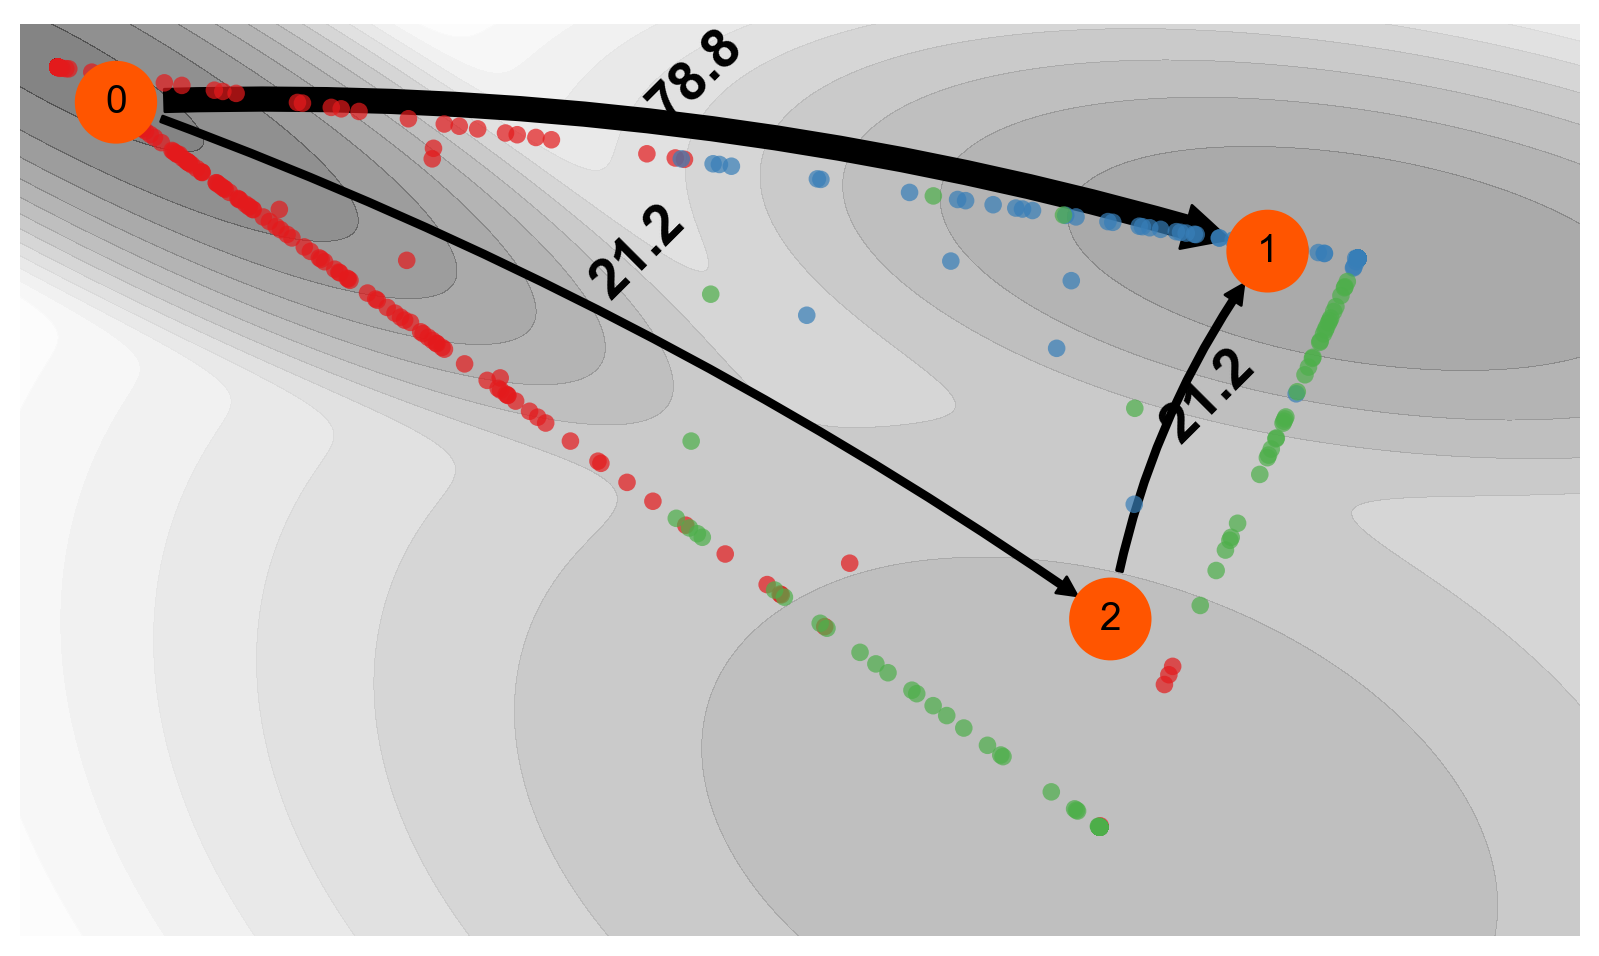

In [4]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 0,sf = 1, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_0_to_1_100.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_0_to_1_100.png")

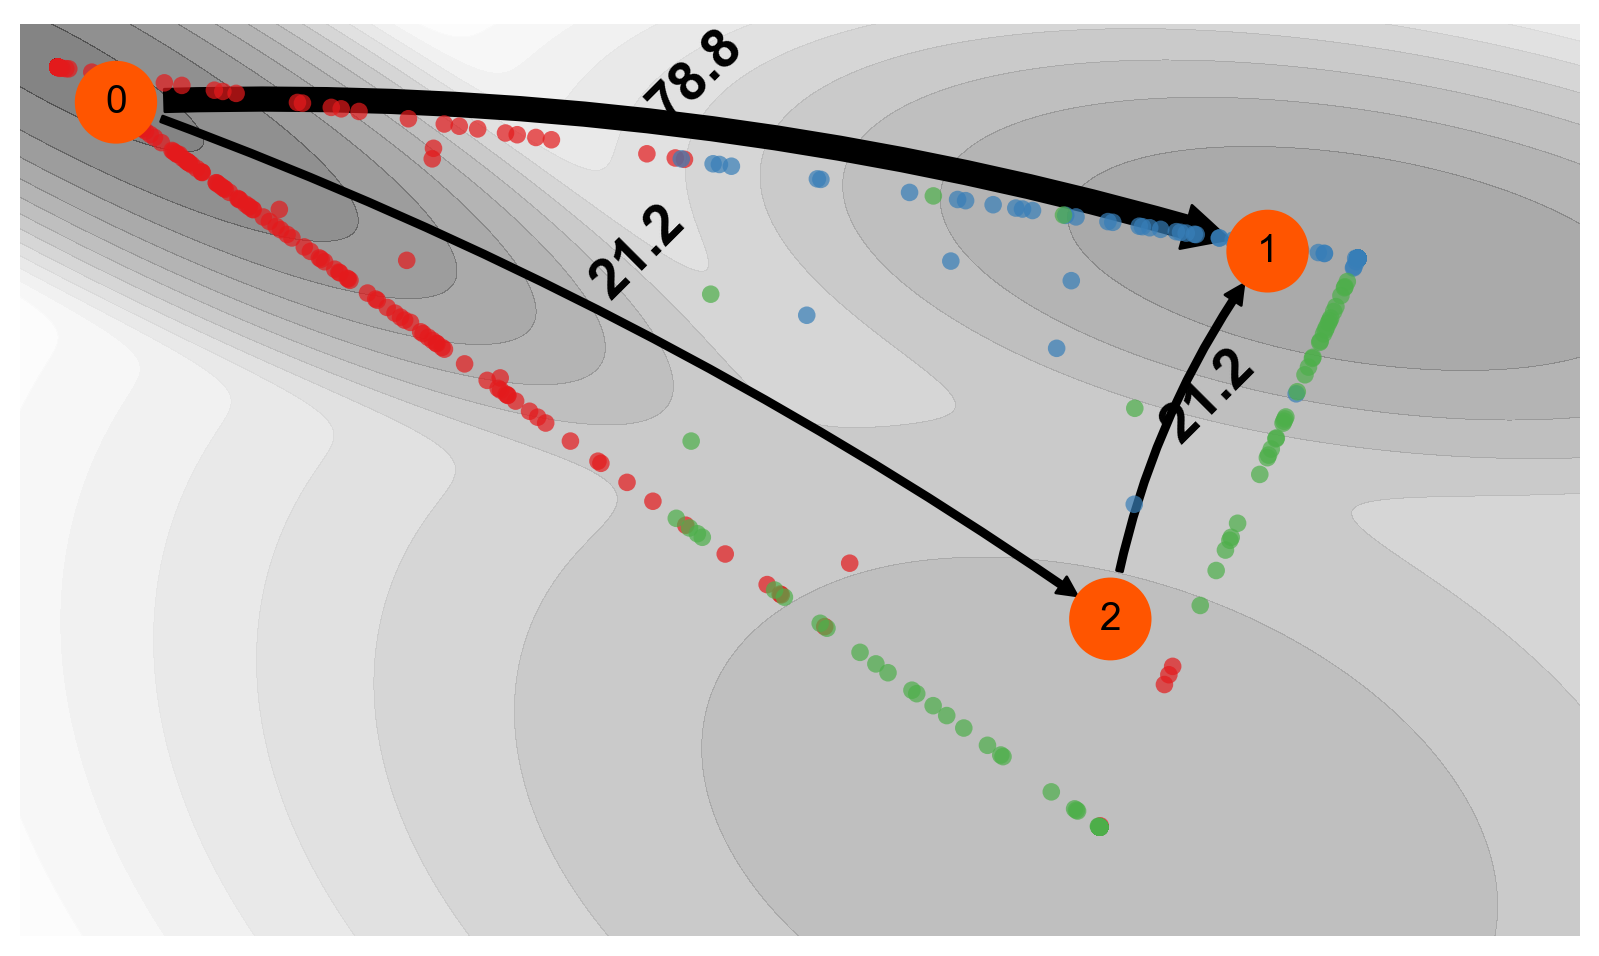

In [5]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 0,sf = 1, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_0_to_1_90.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_0_to_1_90.png")

MPPT from 0 to 2

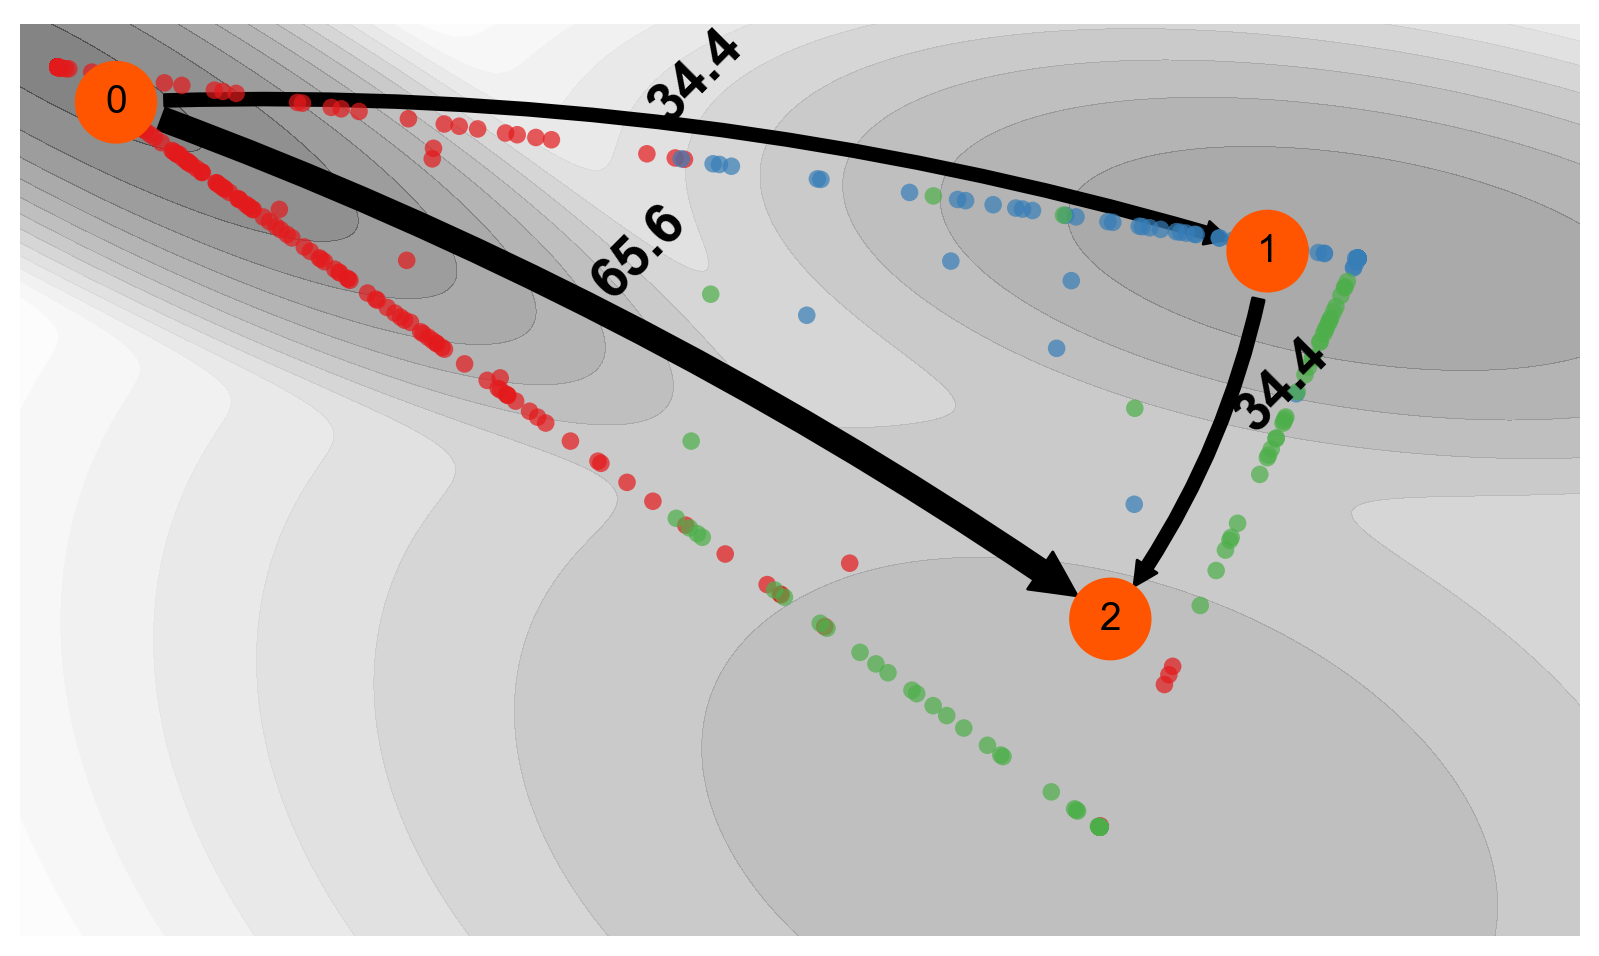

In [6]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 0,sf = 2, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_0_to_2_100.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_0_to_2_100.png")

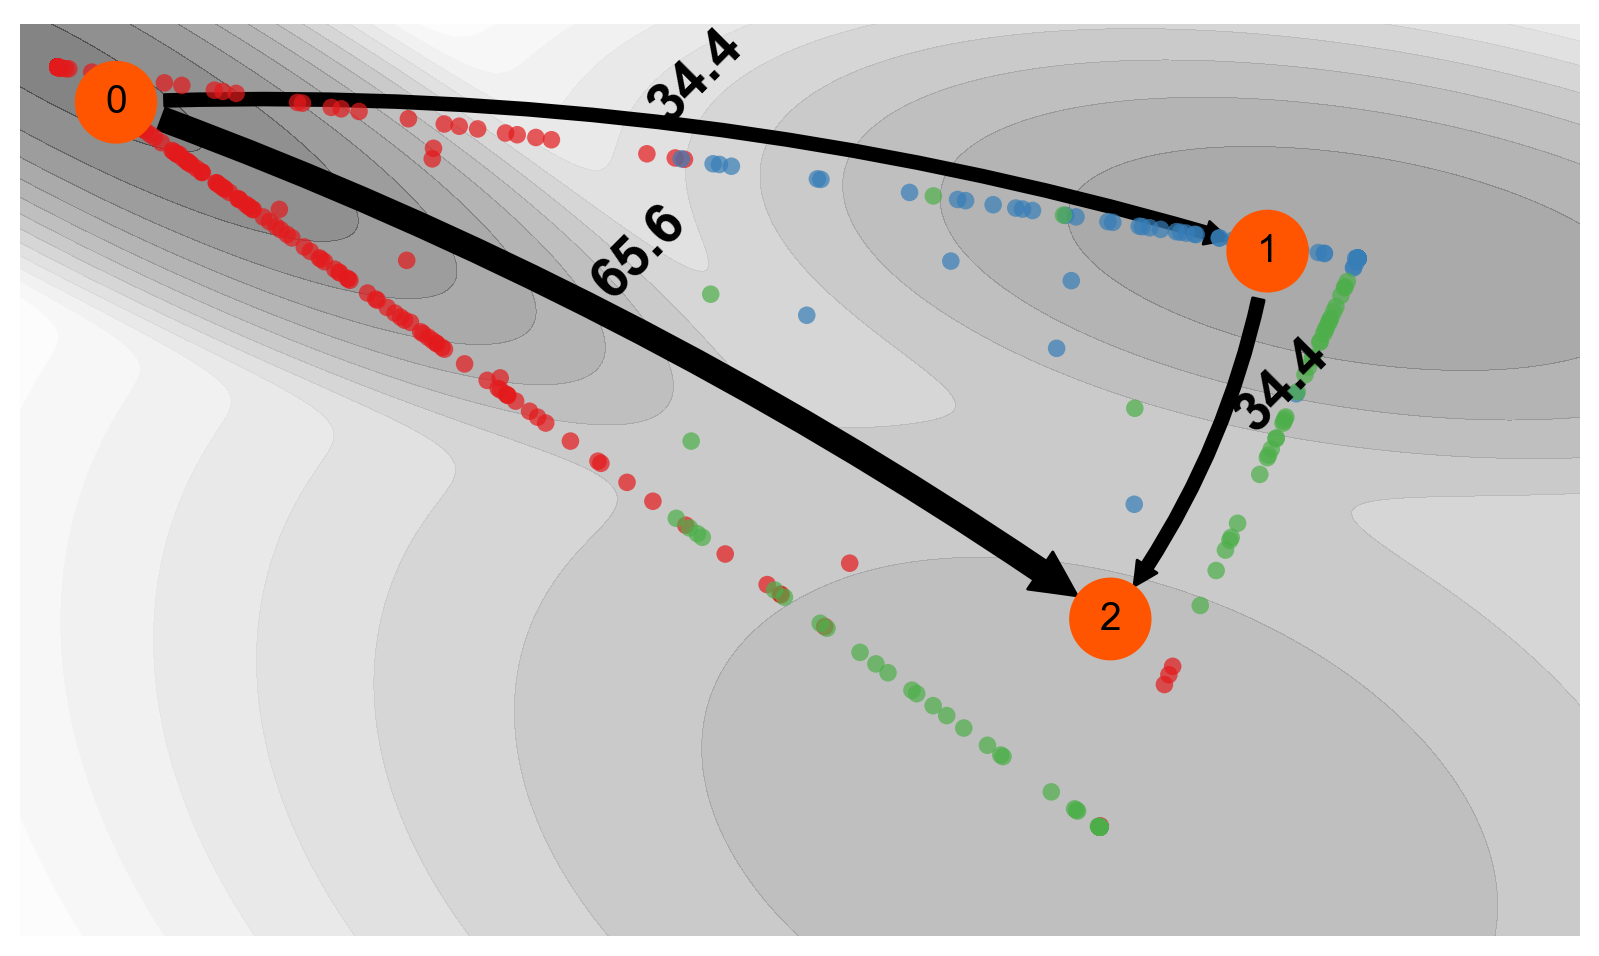

In [7]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 0,sf = 2, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_entry_mppt_0_to_2_90.pdf")
plt.savefig(plotdir+"pdx_entry_mppt_0_to_2_90.png")

In [ ]:
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')

In [ ]:
color_palette = sns.color_palette('Set1', 3)
sc.pl.umap(adata_mu, color = ['attractor', 'entropy', 'PHOX2B', 'PRRX1'], vmax = 'p95', palette = color_palette, show = False)
plt.savefig(plotdir+"pdx_entry_umap_attractor_entropy.pdf")
plt.savefig(plotdir+"pdx_entry_umap_attractor_entropy.png")

In [ ]:
for keys in list(adata_mu.uns['da_out'].keys()):
    if type(adata_mu.uns['da_out'][keys]).__name__ == 'double':
        adata_mu.uns['da_out'][keys] = np.asarray(adata_mu.uns['da_out'][keys])    

for keys in list(adata_mu.uns['land'].keys()):
    if type(adata_mu.uns['land'][keys]).__name__ == 'double':
        adata_mu.uns['land'][keys] = np.asarray(adata_mu.uns['land'][keys])    

del adata_mu.uns['land']['model']

adata_mu.write(datadir+'pdx_entry_mutrans.h5ad')

In [ ]:
del adata_mu.uns['da_out']
del adata_mu.uns['land']

In [ ]:
adata_mu.write_h5ad(
    datadir+"pdx_entry_mutrans_mod.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

### Attractor annotation

In [2]:
plotdir = "../plots/pdx_entry/"

In [3]:
adata_mu = sc.read(datadir+'pdx_entry_mutrans.h5ad')
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')
color_palette = sns.color_palette('Set1', 3)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
conditions = [
    adata_mu.obs['attractor'] == 0,
    adata_mu.obs['attractor'] == 1,
    adata_mu.obs['attractor'] == 2
]

outputs = [
    'I', 'II', 'III'
]

In [5]:
adata_mu.obs['energy_rank'] = np.select(conditions, outputs)

In [6]:
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[2]
}

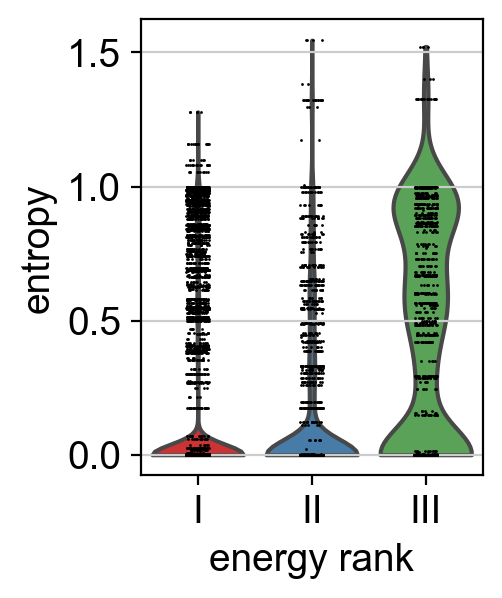

In [7]:
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.violin(adata_mu, keys = 'entropy', groupby='energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_entry_violin_attractor_entropy_ranked.pdf")
plt.savefig(plotdir+"pdx_entry_violin_attractor_entropy_ranked.png")

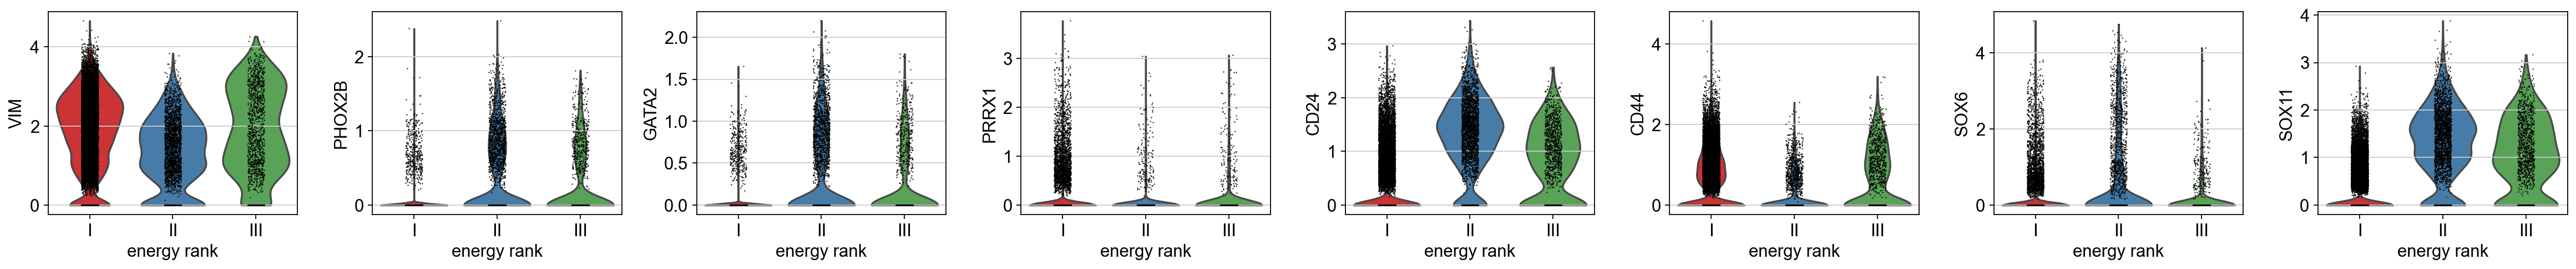

In [8]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['VIM','PHOX2B','GATA2','PRRX1','CD24','CD44','SOX6','SOX11'], groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_entry_violin_markers_ranked.pdf")
plt.savefig(plotdir+"pdx_entry_violin_markers_ranked.png")

In [9]:
adata_mu.write_h5ad(
    datadir+"pdx_entry_mutrans_ranked.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)

#### Hybrid signature

In [ ]:
plotdir = "../plots/pdx_entry/"
adata_mu = sc.read(datadir+'pdx_entry_mutrans_ranked.h5ad')
color_palette = sns.color_palette('Set1', 3)
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[2]
}

In [10]:
hyb_sig = pd.read_csv(datadir+"method2_dge.csv")

In [11]:
hyb_list = hyb_sig['gene'].tolist()

In [12]:
sc.tl.score_genes(adata_mu, gene_list=hyb_list, ctrl_size=len(hyb_list), score_name="HYB.Sig")

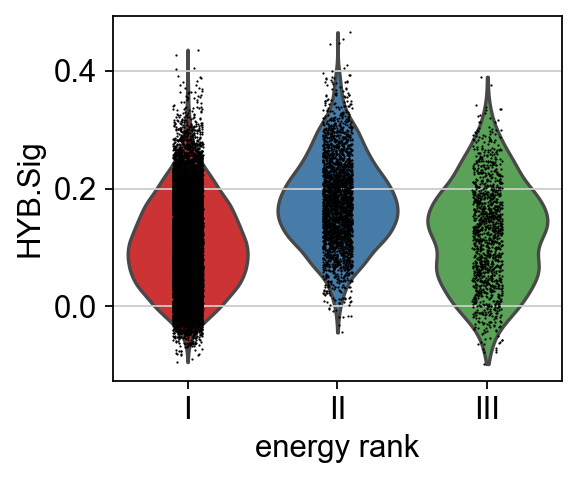

In [13]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = 'HYB.Sig', groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_entry_violin_hyb_ranked.pdf")
plt.savefig(plotdir+"pdx_entry_violin_hyb_ranked.png")

#### Dyer signature

In [ ]:
plotdir = "../plots/pdx_entry/"
adata_mu = sc.read(datadir+'pdx_entry_mutrans_ranked.h5ad')
color_palette = sns.color_palette('Set1', 3)
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[2]
}

In [14]:
dyer_df = pd.read_csv(datadir+"Dyer_Sig.csv", header=None)
dyer_df.columns = ["Gene", "Signature"]

In [15]:
dyer_sig = {sig: dyer_df[dyer_df['Signature'] == sig]['Gene'].tolist() for sig in dyer_df['Signature'].unique()}
gene_lists = list(dyer_sig.values())

In [16]:
for gene_list, score_name in zip(gene_lists, ['MES.Dyer', 'SYMP.Dyer', 'ADRN.Dyer']):
    sc.tl.score_genes(adata_mu, gene_list=gene_list, score_name=score_name, random_state=12345)

In [ ]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['MES.Dyer', 'SYMP.Dyer', 'ADRN.Dyer'], groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_entry_violin_dyer_ranked.pdf")
plt.savefig(plotdir+"pdx_entry_violin_dyer_ranked.png")

## PDX exit

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
import matplotlib.pyplot as plt
import pyMuTrans as pm
import hdf5plugin
import gc
import seaborn as sns

datadir = "data/"

In [ ]:
adata = sc.read(datadir+'pdx_exit_seurat.h5ad')
adata

In [ ]:
adata.layers["raw_counts"] = adata.raw.X
adata.layers["seurat_lognorm"] = adata.X
adata.X = adata.raw.X

In [ ]:
adata.obs = adata.obs[['Sample', 'Barcode', 'description', 'Model', 'Condition', 'Rec', 'Replicate', 'batch', 'Sample_Type', 'seurat_clusters', 'MES.Sig', 'ADRN.Sig', 'AMT.Sig', 'AMT.score', 'AMT.state', 'Cluster_Name', 'Coexprs.Sig']]
adata.obsm = []
adata

In [ ]:
# Check adata has raw counts matrix
df = pd.DataFrame.sparse.from_spmatrix(adata.X)
df.head(10)

In [ ]:
sc.pp.subsample(adata, n_obs=20000)
adata

### Pre-processing

Quick QC

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

Normalisation

In [ ]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
# Set .raw attribute of AnnData object to the normalised and logarithmized raw gene expression
adata.raw = adata
# Filter for highly variable genes
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [ ]:
sc.pp.scale(adata, max_value = 10) # Clips values exceeding sd = 10

Reduced dims

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack')

In [ ]:
sc.pl.pca(adata, color = ['PHOX2B','PRRX1'])

In [ ]:
sc.pl.pca_variance_ratio(adata, log = True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color = ['PHOX2B', 'PRRX1'])

Clustering

In [ ]:
sc.tl.leiden(adata, resolution = 0.1)

In [ ]:
sc.pl.umap(adata, color = ['leiden', 'PHOX2B', 'PRRX1'])

In [ ]:
adata.write_h5ad(
    datadir+"pdx_exit_scanpy.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

Marker genes

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

PAGA analysis

In [ ]:
adata = sc.read(datadir+"pdx_exit_scanpy.h5ad")

In [ ]:
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, color = 'leiden')


In [ ]:
sc.pl.paga(adata, color = ['PHOX2B', 'PRRX1'])

### Mutrans analysis

In [ ]:
sc.tl.tsne(adata, n_pcs = 30)

In [ ]:
sc.pp.neighbors(adata, metric = 'cosine', n_neighbors = 60, use_rep = 'X')

In [ ]:
adata.write_h5ad(
    datadir+"pdx_exit_scanpy_nn.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

#### Start run from here

In [2]:
plotdir = "../plots/pdx_exit/"

In [3]:
adata = sc.read(datadir+"pdx_exit_scanpy_nn.h5ad")

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
gc.collect()

12

In [ ]:
par = {"choice_distance":"cosine","K_cluster":4.0,"trials":50,"weight_scale":True,"initial":"pca","reduce_large_scale":True,"reduce_num_meta_cell":1000.0,"fig_name": plotdir+"dynam_out"} 
adata_mu = pm.dynamical_analysis(adata, par)
out = adata_mu.uns['da_out']
ind = np.argsort(np.asarray(out['perm_class']).ravel().astype(int)-1)
labels_in_meta = np.asarray(out['reduce_class']).ravel().astype(int)-1
attractor_meta = np.asarray(out['class_order']).ravel()[ind]-1
adata_mu.obs['attractor'] = [ int(attractor_meta[labels_in_meta[i]]) for i in range(len(labels_in_meta))]
entropy_meta = np.asarray(out['H']).ravel()[ind]
adata_mu.obs['entropy'] = [entropy_meta[labels_in_meta[i]] for i in range(len(labels_in_meta))]

In [ ]:
adata_mu

In [ ]:
np.asarray(adata_mu.uns['da_out']['mu_hat'])

In [ ]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, method = "MPFT", size_point = 40, alpha_point = 0.5, size_text = 15)
plt.savefig(plotdir+"pdx_exit_mpft.pdf")
plt.savefig(plotdir+"pdx_exit_mpft.png")

MPPT from 1 to 2

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 2, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_1_to_2_100.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_1_to_2_100.png")

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 1,sf = 2, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_1_to_2_90.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_1_to_2_90.png")

MPPT from 2 to 1

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 2,sf = 1, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_2_to_1_100.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_2_to_1_100.png")

In [ ]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 2,sf = 1, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_2_to_1_90.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_2_to_1_90.png")

MPPT from 1 to 3

In [ ]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 1,sf = 3, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_1_to_3_100.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_1_to_3_100.png")

In [ ]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 1, sf = 3, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_1_to_3_90.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_1_to_3_90.png")

MPPT from 3 to 1

In [ ]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 3,sf = 1, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_3_to_1_100.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_3_to_1_100.png")

In [ ]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, si = 3, sf = 1, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"pdx_exit_mppt_3_to_1_90.pdf")
plt.savefig(plotdir+"pdx_exit_mppt_3_to_1_90.png")

In [ ]:
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')

In [ ]:
color_palette = sns.color_palette('Set1', 4)
sc.pl.umap(adata_mu, color = ['attractor', 'entropy', 'PHOX2B', 'PRRX1'], vmax = 'p95', palette = color_palette, show = False)
plt.savefig(plotdir+"pdx_exit_umap_attractor_entropy.pdf")
plt.savefig(plotdir+"pdx_exit_umap_attractor_entropy.png")

In [ ]:
for keys in list(adata_mu.uns['da_out'].keys()):
    if type(adata_mu.uns['da_out'][keys]).__name__ == 'double':
        adata_mu.uns['da_out'][keys] = np.asarray(adata_mu.uns['da_out'][keys])    

for keys in list(adata_mu.uns['land'].keys()):
    if type(adata_mu.uns['land'][keys]).__name__ == 'double':
        adata_mu.uns['land'][keys] = np.asarray(adata_mu.uns['land'][keys])    

del adata_mu.uns['land']['model']

adata_mu.write(datadir+'pdx_exit_mutrans.h5ad')

In [ ]:
del adata_mu.uns['da_out']
del adata_mu.uns['land']

In [ ]:
adata_mu.write_h5ad(
    datadir+"pdx_exit_mutrans_mod.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

### Attractor annotation

In [2]:
plotdir = "../plots/pdx_exit/"

In [3]:
adata_mu = sc.read(datadir+'pdx_exit_mutrans.h5ad')
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')
color_palette = sns.color_palette('Set1', 4)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
conditions = [
    adata_mu.obs['attractor'] == 0,
    adata_mu.obs['attractor'] == 1,
    adata_mu.obs['attractor'] == 2,
    adata_mu.obs['attractor'] == 3
]

outputs = [
    'I', 'II', 'IV', 'III'
]

In [5]:
adata_mu.obs['energy_rank'] = np.select(conditions, outputs)

In [6]:
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[3],
    'IV' : color_palette[2]
}

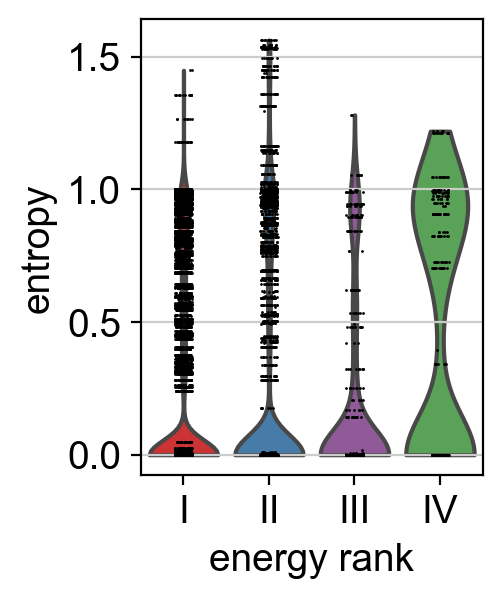

In [7]:
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.violin(adata_mu, keys = 'entropy', groupby='energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_exit_violin_attractor_entropy_ranked.pdf")
plt.savefig(plotdir+"pdx_exit_violin_attractor_entropy_ranked.png")

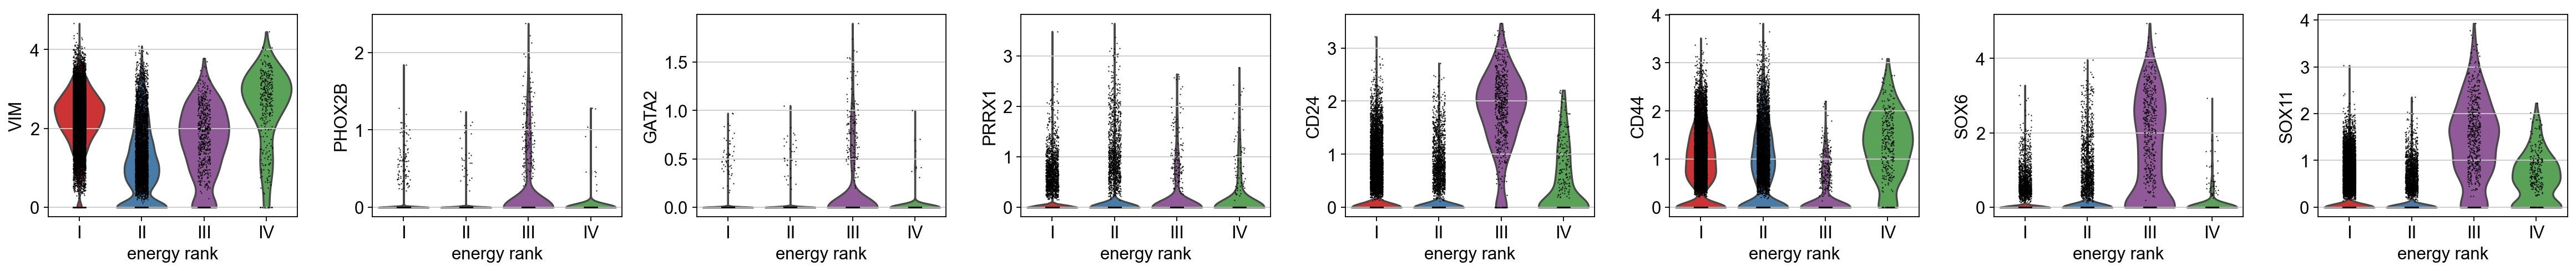

In [8]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['VIM','PHOX2B','GATA2','PRRX1','CD24','CD44','SOX6','SOX11'], groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_exit_violin_markers_ranked.pdf")
plt.savefig(plotdir+"pdx_exit_violin_markers_ranked.png")

In [9]:
adata_mu.write_h5ad(
    datadir+"pdx_exit_mutrans_ranked.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)

#### Hybrid signature

In [ ]:
plotdir = "../plots/pdx_exit/"
adata_mu = sc.read(datadir+'pdx_exit_mutrans_ranked.h5ad')
color_palette = sns.color_palette('Set1', 4)
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[3],
    'IV' : color_palette[2]
}

In [10]:
hyb_sig = pd.read_csv(datadir+"method2_dge.csv")

In [11]:
hyb_list = hyb_sig['gene'].tolist()

In [12]:
sc.tl.score_genes(adata_mu, gene_list=hyb_list, ctrl_size=len(hyb_list), score_name="HYB.Sig")

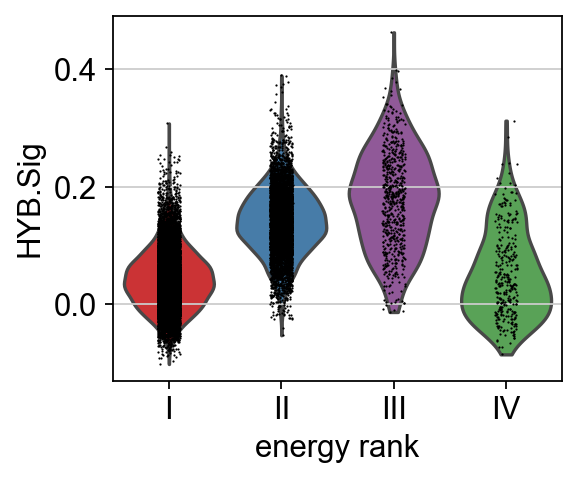

In [13]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = 'HYB.Sig', groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_exit_violin_hyb_ranked.pdf")
plt.savefig(plotdir+"pdx_exit_violin_hyb_ranked.png")

#### Dyer signature

In [ ]:
plotdir = "../plots/pdx_exit/"
adata_mu = sc.read(datadir+'pdx_exit_mutrans_ranked.h5ad')
color_palette = sns.color_palette('Set1', 4)
energy_pal = {
    'I' : color_palette[0],
    'II' : color_palette[1],
    'III' : color_palette[3],
    'IV' : color_palette[2]
}

In [14]:
dyer_df = pd.read_csv(datadir+"Dyer_Sig.csv", header=None)
dyer_df.columns = ["Gene", "Signature"]

In [15]:
dyer_sig = {sig: dyer_df[dyer_df['Signature'] == sig]['Gene'].tolist() for sig in dyer_df['Signature'].unique()}
gene_lists = list(dyer_sig.values())

In [16]:
for gene_list, score_name in zip(gene_lists, ['MES.Dyer', 'SYMP.Dyer', 'ADRN.Dyer']):
    sc.tl.score_genes(adata_mu, gene_list=gene_list, score_name=score_name, random_state=12345)

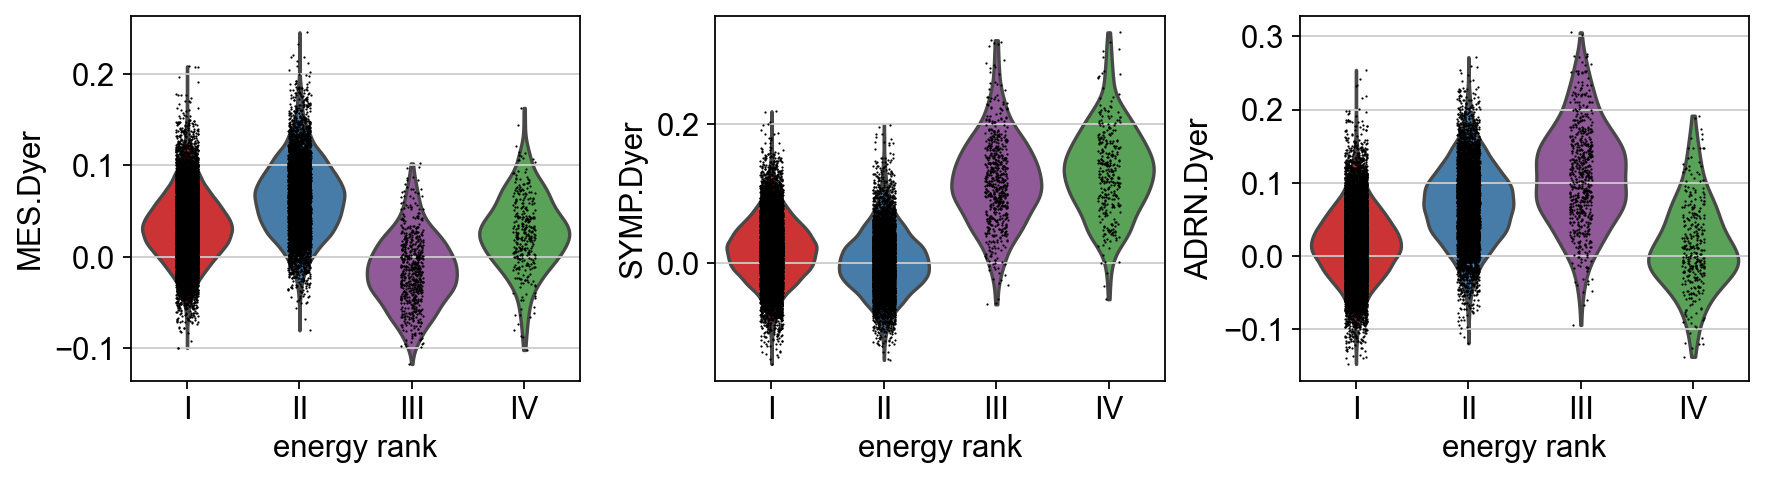

In [17]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['MES.Dyer', 'SYMP.Dyer', 'ADRN.Dyer'], groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"pdx_exit_violin_dyer_ranked.pdf")
plt.savefig(plotdir+"pdx_exit_violin_dyer_ranked.png")